In [1]:
import pytorch_lightning as pl
import torch.nn as nn
from pytorch_lightning.loggers import WandbLogger
import torch as torch
from pytorch_lightning.callbacks import Callback
import ml_collections
from models.ddpm import DDPM
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, RandomRotation, RandomVerticalFlip, RandomHorizontalFlip, Normalize, Resize, Compose, CenterCrop, RandomCrop
from torchvision.transforms import InterpolationMode
import PIL.Image as Image
import torchvision.transforms.functional as TVF
import numpy as np
from glob import glob
from pytorch_lightning.callbacks import StochasticWeightAveraging
import matplotlib.pyplot as plt
torch.set_float32_matmul_precision('medium')
from EMA import EMA

def norm_range(x: torch.tensor):
    x_min, x_max = x.min(), x.max()
    x = (x - x_min) / (x_max - x_min) * 255
    x = x.to(torch.uint8)
    return x

def unnormalize(x):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(x.device)
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(x.device)

    return x * std + mean    

In [2]:
def create_default_mnist_config():
    config = ml_collections.ConfigDict()

    # data
    data = config.data = ml_collections.ConfigDict()
    data.image_size = 128
    data.num_channels = 3
    data.centered = True
    data.batch_size = 64 

    # model
    model = config.model = ml_collections.ConfigDict()
    model.ema_rate = 0.99
    model.nf = 32
    model.ch_mult = (1, 2, 2, 2)
    model.num_res_blocks = 3
    model.attn_resolutions = (16,)
    model.dropout = 0.1
    model.resamp_with_conv = True
    model.conditional = True
    model.nonlinearity = 'swish'

    #optim
    optim = config.optim = ml_collections.ConfigDict()
    optim.grad_clip_norm = 1.0
    optim.lr = 3e-4
    optim.step_size = 7
    optim.gamma = 0.99
    optim.weight_decay = 0

    # sde
    sde = config.sde = ml_collections.ConfigDict()
    sde.N = 1000
    sde.val_samples = 20

    config.device = 'cuda:0'
    
    return config

config = create_default_mnist_config()

In [4]:
class SoloToPair:
    def __init__(self, augment, p=1):
        self.augment = augment
        self.p = p

    def __call__(self, *args):
        if self.p == 1 or torch.rand(1) < self.p:
            args = [self.augment(im) for im in args]
            
        return args

class PairedCompose:
    def __init__(self, func_list):
        self.func_list = func_list
    
    def __call__(self, *args):
        for curr_func in self.func_list:
            args = curr_func(*args)
            
        return args

class PairCrop:
    def __init__(self, size, p):
        self.h, self.w = size
        self.p = p
    
    def __call__(self, *args):
        if self.p == 1 or torch.rand(1) < self.p:
            _, H, W = args[0].shape
            assert self.h < H and self.w < W
            dH = (torch.rand(1) * (H - self.h)).to(torch.int32)
            dW = (torch.rand(1) * (W - self.w)).to(torch.int32)

            args = [TVF.crop(img, top=dH, left=dW, height=self.h, width=self.w) for img in args]
        
        return args
            
class PairBlur:
    def __init__(self, kernel, std_range, p):
        self.kernel = kernel
        self.std_range = std_range
        self.p = p 

    def __call__(self, img, tar):
        if torch.rand(1) < self.p:
            img = TVF.gaussian_blur(img, self.kernel, self.std_range)
        
        return img, tar

class Pix2PixDataset(Dataset):
    def __init__(self, path, transforms=None, augment=None):
        pair = np.load(path)
        self.imgs = pair[0]
        self.tars = pair[1]

        self.imgs = torch.stack([transforms(p) for p in self.imgs])
        self.tars = torch.stack([transforms(p) for p in self.tars])
        self.augment = augment

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        tar = self.tars[idx]

        if self.augment is not None:
            img, tar = self.augment(img, tar)

        return img, tar


In [5]:
ds_dir = './np_celeba_bigsup'

# train_ds = Pix2PixDataset(
#     path=f'{ds_dir}/train.npz',
#     transforms=Compose([
#         ToTensor(),
#         Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ]),
#     augment=PairedCompose([
#         # PairCrop((192, 192), 1),
#         # SoloToPair(Resize(size=config.data.image_size, interpolation=InterpolationMode.BICUBIC, antialias=True)),
#         SoloToPair(TVF.vflip, 0.5),
#         SoloToPair(TVF.hflip, 0.5),
#         # PairBlur(3, [0.1, 1], 0.3)
#     ])
#     )
val_ds = Pix2PixDataset(
    path=f'{ds_dir}/val.npz',
    transforms=Compose([
        ToTensor(),
        # CenterCrop(192),
        # Resize(size=config.data.image_size, interpolation=InterpolationMode.BICUBIC, antialias=True),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    )

In [6]:
# curr_pair = train_ds[100]
# print(curr_pair[0].shape, curr_pair[1].shape)
# fig, axes = plt.subplots(1, 2, figsize=(15, 15))
# axes[0].imshow(TVF.to_pil_image(norm_range(curr_pair[0])))
# axes[1].imshow(TVF.to_pil_image(norm_range(curr_pair[1])))

In [7]:
# train_dataloader = DataLoader(train_ds, batch_size=config.data.batch_size, shuffle=True, drop_last=True, num_workers=8)
val_dataloader = DataLoader(val_ds, batch_size=config.data.batch_size, shuffle=False, num_workers=8)

In [9]:
class Beta:
    def __init__(self, max_beta=1.5 * 10**(-4), min_beta= 0.1 * 10**(-4)):
        self.a = max_beta 
        self.b = min_beta
    
    def __call__(self, t):
        f = torch.where(
            t < 0.5, 
            2 * (self.a - self.b) * t + self.b,
            2 * (self.b - self.a) * t + (2 * self.a - self.b)
        )
        left_int = torch.where(
            t < 0.5, 
            t * ((self.a  - self.b) * t + self.b),
            (self.b - self.a) * t**2 + (2 * self.a - self.b) * t + 0.5 * (self.b - self.a)
        )
        right_int = 0.5 * (self.a + self.b) - left_int 

        return f, left_int, right_int
    
class CFM(pl.LightningModule):
    def __init__(self, config, beta=Beta()):
        super().__init__()
        self.config = config
        self.h = 1 / config.sde.N
        self.model = DDPM(config)
        self.beta = beta

    def _base_step(self, batch, batch_idx):
        x0, x1 = batch
        t = torch.rand(x0.shape[0], device=x0.device, dtype=x0.dtype)[:, None, None, None]
        t = torch.clip(t, 1e-5, 1 - 1e-5)

        betat, left_int, right_int = self.beta(t)
        denom = left_int + right_int

        xt = left_int * x1 / denom + right_int * x0 / denom
        xt += torch.sqrt(left_int * right_int / denom) * torch.randn_like(xt)

        pred = self.model(xt, torch.squeeze(t))
        tar = betat * (x1 - xt) / (right_int + 1e-9)
        loss = nn.functional.mse_loss(pred, tar)

        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self._base_step(batch, batch_idx)

        self.log('train_loss', loss)

        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._base_step(batch, batch_idx)

        self.log('val_loss', loss)

        if batch_idx == 0:
            img, tar = batch
            val_len = self.config.sde.val_samples

            shift_idx = 15
            sampled = self.predict_step(img[shift_idx:shift_idx+val_len], batch_idx)
            stacked = torch.cat([img[shift_idx:shift_idx+val_len], sampled, tar[shift_idx:shift_idx+val_len]], dim=2)
            log_imgs = [x for x in stacked]
            
            self.logger.log_image(
                key="val_sampled", 
                images=log_imgs, 
                caption=["init-sampled-target"] * len(log_imgs))


        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.config.optim.lr,
            betas=(0.9, 0.999),
            eps=1e-8,
            weight_decay=self.config.optim.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, 
            step_size=self.config.optim.step_size,
            gamma=self.config.optim.gamma)
        return [optimizer], [scheduler]

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        steps = torch.linspace(1e-5, 1, config.sde.N, device=batch.device, dtype=batch.dtype)[:, None]
        x0 = batch

        for curr_t in steps:
            eps = torch.randn_like(x0)
            curr_beta = self.beta(curr_t)[0]
            x0 = x0 + self.h * self.model(x0, curr_t) + torch.sqrt(curr_beta * self.h) * eps
        
        return x0

### Training

In [11]:
model = CFM(
    config, 
    # gamma=gamma
    )
wandb_logger = WandbLogger(project='Flow_matching_SDE', log_model='best')
ema_callback = EMA(config.model.ema_rate, config.device)
# swa_callback = StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=0.8)

trainer = pl.Trainer(
    gradient_clip_val=config.optim.grad_clip_norm, 
    accelerator='gpu',
    logger=wandb_logger,
    callbacks=[ema_callback],
    limit_val_batches=20,
    check_val_every_n_epoch=2,
    # val_check_interval=0.5,
    accumulate_grad_batches=2,
    max_epochs=70
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shtykov-pa. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | DDPM | 2.9 M 
-------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.663    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/miniconda3/envs/mlbase/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Load form checkpoint

In [26]:
# model = CFM.load_from_checkpoint(
#     checkpoint_path='./checkpoints/sde_celeba64_deblur.ckpt',
#     config=config
# )
# model = model.to('cuda:0')
# model = model.eval()

In [27]:
# with torch.no_grad():
#     pred = model.predict_step(val_ds[1][1].repeat(10, 1, 1, 1).to('cuda:0'), 1).cpu()

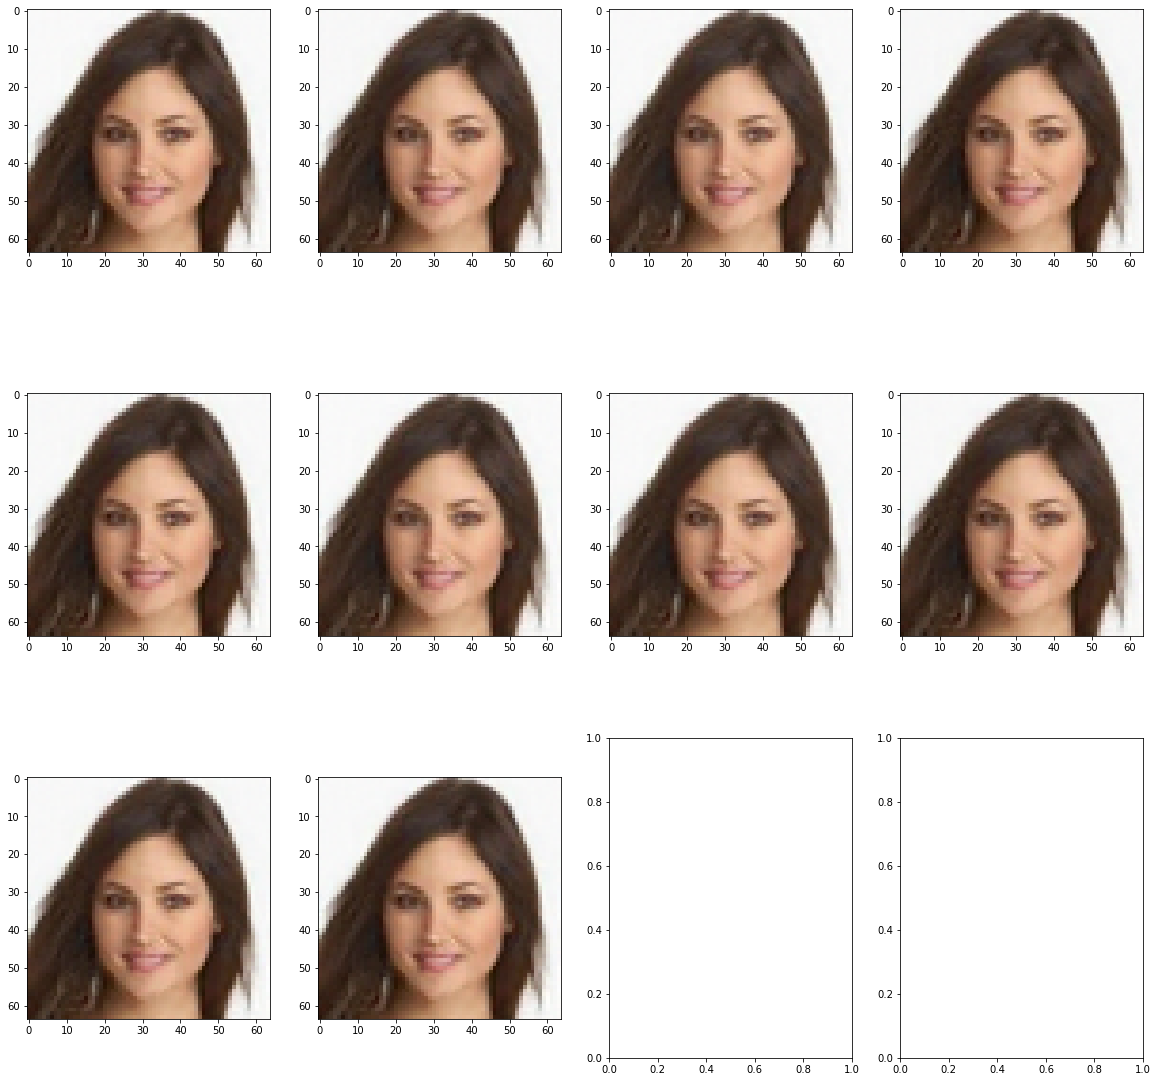

In [35]:
# fig, axes = plt.subplots(3, 4, figsize=(20, 20))
# axes = axes.flatten()

# for i, im in enumerate(pred):
#     axes[i].imshow(TVF.to_pil_image(norm_range(unnormalize(im))))